# AdiabatClimate

`AdiabatClimate` is a simple 1-D climate model which assumes the atmosphere is made of a pseudo-moist adiabat troposphere connected to an isothermal stratosphere. The code accounts for gas condensation, which effects the temperature profile from released latent heat, and pretends that any condensed material immediately leaves the atmosphere.

In [1]:
import numpy as np
import numba as nb
from matplotlib import pyplot as plt
from scipy import constants as const

from clima import AdiabatClimate

from threadpoolctl import threadpool_limits
threadpool_limits(limits=4) # set number of threads. Must come after import of AdiabatClimate

## Initialization

The model can be initialized with the following three files. Check out the `species.yaml` and `settings.yaml` files they are heavily commented to show all possible options. 

In [2]:
species_file = '../templates/runaway_greenhouse/species.yaml' # Species and their thermodynamic properties
settings_file = '../templates/runaway_greenhouse/settings.yaml' # Planet properties, and radiative transfer settings
star_file = '../templates/ModernEarth/Sun_Now.txt' # The stellar flux

c = AdiabatClimate(species_file, 
                   settings_file, 
                   star_file)

In [3]:
print(c.species_names) # species in the model

['H2O', 'CO2', 'N2']


## Constructing an atmosphere

### `make_profile`

Given the surface temperature and volatile inventories `AdiabatClimate` is able to draw a temperature profile and distribute gases in the atmosphere. One function that does this is `AdiabatClimate.make_profile`, which I illustrate below.

In [4]:
# P_i are the partial pressure "reservoirs" of each gas in in dynes/cm2. 
# Order is the same as `c.species_names`.
P_i = np.array([
    260.0, # H2O
    10.0, # CO2
    1.0, # N2
])*1.0e6
T_surf = 280 # surface temperature (K)

c.P_top = 1.0e-2 # pressure of top of the atmosphere (dynes/cm^2). 
c.T_trop = 150 # tropopause temperature (K). 
c.RH = np.ones(len(c.species_names)) # Relative humidity of each species. default is 1.0

# Integrates a multispecies pseudoadiabat upward following
# Equation (1) in Graham et al. 2021 (doi.org/10.3847/PSJ/ac214c)
c.make_profile(T_surf, P_i)

The object `c` now has attributes that describe the atmosphere
- `c.P`, pressures in atmospheric layers (dynes/cm$^2$)
- `c.P_surf` surface pressure (dynes/cm$^2$)
- `c.T`, temperature in atmospheric layers (K)
- `c.f_i`, mixing ratios of all species in atmospheric layers (2-D array)
- `c.z`, altitude of center of atmospheric layers (cm)
- `c.dz`, thickness of each atmospheric layers (cm)
- `c.N_atmos`, reservoir of each gas in the atmosphere (mol/cm$^2$)
- `c.N_surface`, reservoir of each gas on the surface (mol/cm$^2$)
- `c.N_ocean`, reservoir of each gas dissolved in oceans (mol/cm$^2$)

Here are some illustrative plots:

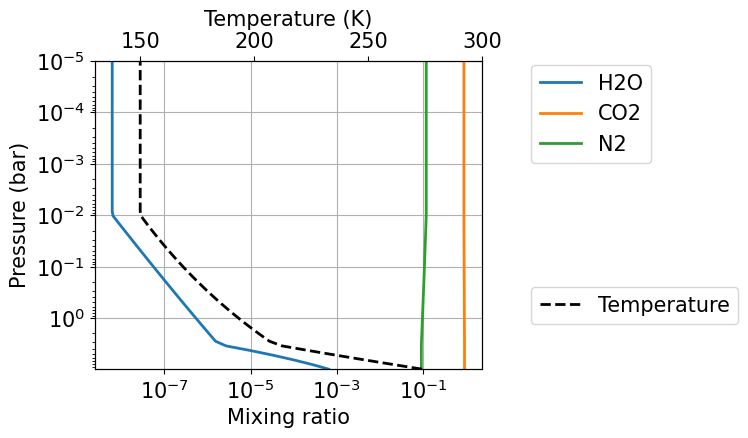

In [5]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

for i in range(len(c.species_names)):
    ax.plot(c.f_i[:,i], c.P/1e6, lw=2, label=c.species_names[i])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(c.P[0]/1e6,1e-5)
ax.legend(ncol=1,bbox_to_anchor=(1.1, 1.02), loc='upper left')
ax.grid()
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Mixing ratio')

ax1 = ax.twiny()

ax1.plot(c.T, c.P/1e6, 'k--', lw=2, label='Temperature')
ax1.set_xlabel('Temperature (K)')
ax1.legend(ncol=1,bbox_to_anchor=(1.1, .3), loc='upper left')
ax1.set_xlim(130,300)

plt.show()

In the figure above, the tropopause is at $10^{-2}$ bars. Below that, in the troposphere, the slope of the temperature profile changes at about 3 bars pressure. This is caused by the start of CO$_2$ condensation.

`c.N_atmos`, `c.N_surface` and `c.N_ocean` contains the reservoir of volatiles in mol/cm$^{2}$ in the atmosphere, surface, and dissolved in oceans. Only gases that are saturated at surface have a surface reservoir. In this case, only water has a surface reservoir, which can be thought of as an ocean. We have not included gas dissolution in oceans, so the model reports no dissolved gases. Later in this notebook we implement gas dissolution in oceans.  

In [6]:
print(c.N_atmos)

[4.70266896e-02 2.39196291e+02 2.43237880e+01]


In [7]:
print(c.N_surface)

[14696.15911658     0.             0.        ]


In [8]:
print(c.N_ocean)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


The surface pressure is about 11.01 bars from 10 bars of CO$_2$, 1 bar of N$_2$ and a little water vapor.

In [9]:
print(c.P_surf/1e6) # bars

11.010013835389936


### `make_column`

`AdiabatClimate.make_column` is another function, similar to `AdiabatClimate.make_profile`, for constructing an atmosphere. The difference is that `AdiabatClimate.make_column` instead accepts column abundances of gases (mol/cm$^2$).

In [10]:
c.T_trop = 200 # change tropopause temperature

T_surf = 280 # surface temperature (K)
N_i = np.array([15.0e3, 23.0, 36.0]) # mol/cm^2
c.make_column(T_surf, N_i)

We can check that the total column abundances matches the inputs. Some water is on the ground.

In [11]:
print(c.N_atmos)
print(c.N_surface)
print(c.N_atmos+c.N_surface)

[ 0.0640347  22.99999999 35.99999999]
[14999.9359653     0.            0.       ]
[15000.            22.99999999    35.99999999]


### `make_profile_bg_gas`

The final function that constructs atmospheres is `AdiabatClimate.make_profile_bg_gas`. This function specifies a surface pressure and a background gas. The background gas is varied in abundance to allow for the specified surface pressure.

In [12]:
T_surf = 280 # surface temperature (K)
P_i = np.array([260.0, 1.0, 1.0])*1.0e6
P_surf = 2.0e6 # dynes/cm^2
bg_gas = 'N2'
c.make_profile_bg_gas(T_surf, P_i, P_surf, bg_gas)

# Surface pressure
print(c.P_surf)

1999999.999999999


The model will fail if you specify a surface pressure that can not be satisfied. For example, a 0.5 bar atmosphere is not possible with these inputs because there must be at least 1 bar of CO$_2$ in the atmosphere.

In [13]:
# Uncoment and run to see the error
# P_surf = 0.5e6 # dynes/cm^2
# c.make_profile_bg_gas(T_surf, P_i, P_surf, bg_gas)

## Radiative transfer

So far this notebook has shown a variety of methods (`make_profile`, `make_column`, and `make_profile_bg_gas`) for constructing atmospheres. `AdiabatClimate` had complementary methods which construct atmosphere, then subsequently compute shortwave and long-wave radiative transfer.

- `AdiabatClimate.TOA_fluxes` calls `AdiabatClimate.make_profile` then does radiative transfer on the constructed atmosphere.
- `AdiabatClimate.TOA_fluxes_column` calls `AdiabatClimate.make_column` then does radiative transfer on the constructed atmosphere.
- `AdiabatClimate.TOA_fluxes_bg_gas` calls `AdiabatClimate.make_profile_bg_gas` then does radiative transfer on the constructed atmosphere.

Each function returns the incoming solar energy and outgoing long-wave energy at the top of the atmosphere. In the examples below I use `TOA_fluxes`, but the other two functions work in a very similar way.

In [14]:
P_i = np.array([260.0, 400.0e-6, 1.0])*1.0e6
T_surf = 280
c.T_trop = 215
c.RH = np.ones(len(c.species_names))

# Call TOA fluxes
ISR, OLR = c.TOA_fluxes(T_surf, P_i)
print(ISR) # mW/m^2
print(OLR) # mW/m^2

252565.94156389553
246405.5776455611


We can use these functions to compute the famous "runaway greenhouse limit". This is the maximum radiation that a steam-dominated atmosphere can emit based on the optical properties of water. [Goldblatt et al. (2013)](https://doi.org/10.1038/ngeo1892) is a good paper that explains this phenomenon in more detail.

In [15]:
# Lets check the runway greenhouse limit
P_i = np.array([200.0, 1.0e-10, 1.0])*1.0e6
TT = np.linspace(216,2000,100)
OLR = np.empty(TT.shape[0])
ISR = np.empty(TT.shape[0])
for i,T in enumerate(TT):
    ISR_, OLR_ = c.TOA_fluxes(T, P_i)
    OLR[i] = OLR_/1.0e3
    ISR[i] = ISR_/1.0e3

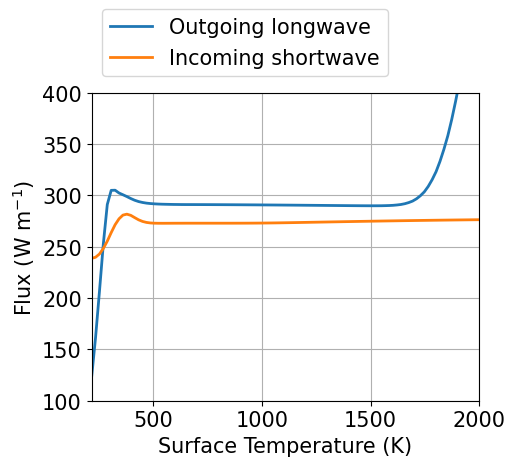

In [16]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

ax.plot(TT,OLR,lw=2, label='Outgoing longwave')
ax.plot(TT,ISR,lw=2, label='Incoming shortwave')

ax.grid()
ax.set_ylabel('Flux (W m$^{-1}$)')
ax.set_xlabel('Surface Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
ax.set_ylim(100,400)
ax.set_xlim(min(TT),max(TT))

plt.show()

In the plot above, you can see that the outgoing long-wave radiation plateaus for 500 K < T < 1700 K. This is the runway greenhouse limit.

In [17]:
# runway greenhouse limit is:
ISR, OLR = c.TOA_fluxes(500, P_i)
print("Runway greenhouse limit = %f W/m^2"%(OLR/1e3))

Runway greenhouse limit = 291.820892 W/m^2


You can also look at the radiation as a function of wavelength. Here we consider a case that roughly reproduces Fig. 1c, 300 K case in [Goldblatt et al. (2013)](https://doi.org/10.1038/ngeo1892)

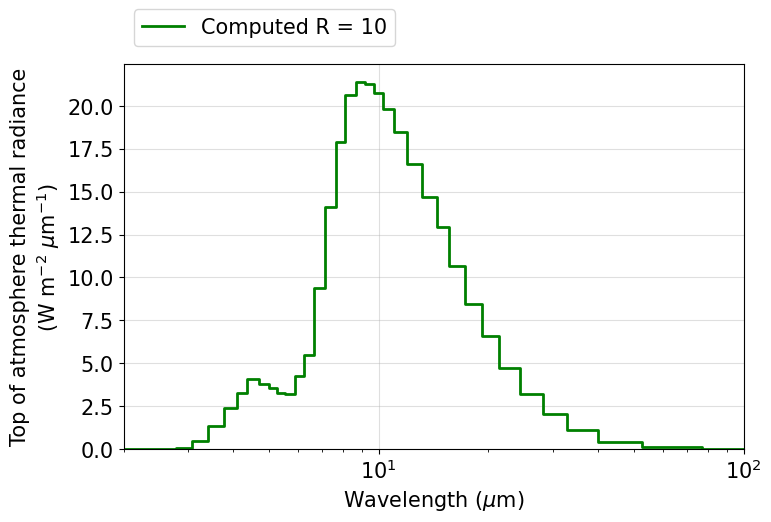

In [18]:
P_i = np.array([270.0, 1e-20, 1e-20])*1.0e6
T_surf = 300
ISR, OLR = c.TOA_fluxes(T_surf, P_i)

freq = c.rad.ir.freq # Hz
freq_av = (freq[1:]+freq[:-1])/2 # Hz
wv_av = 1e6*const.c/freq_av # microns
# c.rad.wrk_ir.fup_a is mW/m^2/Hz. Here I convert to W/m^2/um
F = 1e-3*c.rad.wrk_ir.fup_a[-1,:]*(freq_av/(wv_av))

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[8,5])

ax.plot(wv_av, F, drawstyle='steps-pre',lw=2,c='g',label='Computed R = 10')

ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
ax.set_xscale("log")
ax.set_xlim(2,100)
ax.set_ylim(0,ax.get_ylim()[1])
ax.grid(alpha=0.4)

ax.set_ylabel('Top of atmosphere thermal radiance\n(W m$^{-2}$ $\mu$m$^{-1}$)')
ax.set_xlabel('Wavelength ($\mu$m)')

plt.show()

## Steady-state climate modeling

Up to this point we have merely constructed atmospheres and computed their radiative properties. In this section we calculate steady-state climates. To find steady states, we numerically solve (via a variation of Newton's method) for the surface temperature which constructs an atmosphere that has balanced incoming solar and outgoing long-wave radiation. There are three climate functions, corresponding to our three methods of constructing an atmosphere

- `AdiabatClimate.surface_temperature` uses `AdiabatClimate.make_profile`
- `AdiabatClimate.surface_temperature_column` uses `AdiabatClimate.make_column`
- `AdiabatClimate.surface_temperature_bg_gas` uses `AdiabatClimate.make_profile_bg_gas`

Here are some examples:

In [19]:
P_i = np.array([270.0, 400.0e-6, 1.0])*1.0e6
T_surf = c.surface_temperature(P_i, T_guess = 280) # optionally include a guess for T_surf
print(T_surf)

284.1250475717639


In [20]:
N_i = np.array([15.0e3, 400.0e-6*23.0, 36.0])
T_surf = c.surface_temperature_column(N_i, T_guess = 280)
print(T_surf)

282.5145086613296


In [21]:
P_i = np.array([270.0, 400.0e-6, 1.0])*1.0e6
P_surf = 1.0e6
bg_gas = "N2"
T_surf = c.surface_temperature_bg_gas(P_i, P_surf, bg_gas, T_guess = 280)
print(T_surf)

284.15300201482853


Since this steady-state modeling involves solving a non-linear equation, the algorithm can sometimes fail. Failure can be caused by a bad initial starting guess, or it is also possible that there is no steady-state climate for the chosen inputs. Another possibility is that there are multiple steady-state climates. Make sure to proceed with caution.

## The ice-albedo feedback
As Earth gets colder, the ice caps get bigger. More ice means the surface reflects more sunlight, which in turn might make the Earth even colder. This effect is known as the ice-albedo feedback. This part of the tutorial shows how you can implement an ice-albedo feedback in `AdiabatClimate`.

The function below parameterizes the ice-albedo feedback following [Arney et al. 2016](https://www.liebertpub.com/doi/full/10.1089/ast.2015.1422) (with some modifications).

In [22]:
@nb.cfunc(nb.double(nb.double))
def arney_ice_albedo_feedback(T):
    if T <= 240:
        albedo = 0.65
    elif 240 < T <= 290:
        albedo = 0.65 + (0.2 - 0.65)*((T-240)/(290-240))**0.37
    elif T > 290:
        albedo = 0.2
    return albedo

In [23]:
c.T_trop = 200
c.albedo_fcn = arney_ice_albedo_feedback # sets the feedback function

N_i = np.array([15.0e3, 400.0e-6*23.0, 36.0])
TT = np.linspace(201,310,100)
OLR = np.empty(TT.shape[0])
ISR = np.empty(TT.shape[0])
albedo = np.empty(TT.shape[0])
for i,T in enumerate(TT):
    ISR_, OLR_ = c.TOA_fluxes_column(T, N_i)
    OLR[i] = OLR_/1.0e3
    ISR[i] = ISR_/1.0e3
    albedo[i] = c.rad.surface_albedo

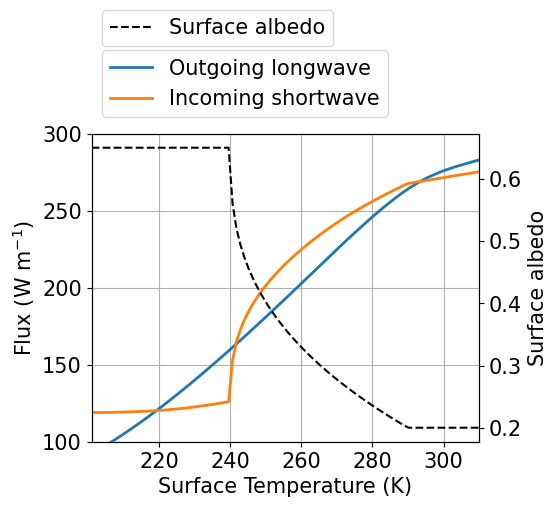

In [24]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

ax.plot(TT,OLR,lw=2, label='Outgoing longwave')
ax.plot(TT,ISR,lw=2, label='Incoming shortwave')

ax.grid()
ax.set_ylabel('Flux (W m$^{-1}$)')
ax.set_xlabel('Surface Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
ax.set_ylim(100,300)
ax.set_xlim(min(TT),max(TT))

ax1 = ax.twinx()
ax1.plot(TT, albedo, c='k', ls='--', label='Surface albedo')
ax1.set_ylabel('Surface albedo')
ax1.legend(ncol=1,bbox_to_anchor=(0, 1.25), loc='lower left')

plt.show()

In the figure above, you can see two stable climates. One is cold (T = 220 K) with high albedo. This represents Earth in an ice-ball state. Another stable climate is about ~290 K with a low albedo, which represents Earth with little ice, similar to today.

There is an additional unstable equilibrium climate at ~240 K. This is unstable because if the planet gets warmer by a small amount, then the incoming solar radiation would be greater than the outgoing longwave radiation. So, the planet would warm until it reached the stable warm climate.

In [25]:
c.T_trop = 215 # restore T_trop
c.albedo_fcn = None # remove albedo feedback
c.rad.surface_albedo = 0.25 # restore albedo

## Gas dissolution in an ocean

Here we add the complexity of a surface ocean which gases can dissolve into. We will consider a ocean of H$_2$O, but the model can account for gas dissolution in other more exotic oceans (e.g. CO$_2$ ocean?). For N$_2$, gas dissolution is very simple because it is governed by [Henry's law](https://en.wikipedia.org/wiki/Henry%27s_law) and, to first order, there is no further chemistry in the ocean that complicates things. CO$_2$ is much more complicated because of further reactions that occur in the aqueous phase:

$$\mathrm{CO_2}(\mathrm{g}) \leftrightarrow \mathrm{CO_2}(\mathrm{aq}) \tag{1} \label{eq:co2_dis1}$$
$$\mathrm{CO_2}(\mathrm{aq}) + \mathrm{H_2O} \leftrightarrow \mathrm{H^+} + \mathrm{HCO_3^-} \tag{2} \label{eq:co2_dis2}$$
$$\mathrm{HCO_3^-} \leftrightarrow \mathrm{H^+} + \mathrm{CO_3^{2-}} \tag{3} \label{eq:co2_dis3}$$

The total reservoir of CO$_2$ in the ocean is the sum of the aqueous $\mathrm{CO_2}$, $\mathrm{HCO_3^-}$ and $\mathrm{CO_3^{2-}}$. Below I write down some functions which account for N$_2$ solubility, and CO$_2$ solubility as well as CO$_2$ ocean chemistry. The final function, `water_ocean_solubility_fcn`, is a `numba.cfunc` that can be passed to the model. The function has to have the exact signature that I give in the example.

In [26]:
@nb.njit()
def N2_henrys_constant(T):
    alpha = 0.00060*np.exp(1300.0*((1/T) - 1/(298.15))) # mol/(kg*bar)
    return alpha

@nb.njit()
def CO2_henrys_constant(T):
    # from NIST
    alpha = 0.035*np.exp(2400.0*((1/T) - 1/(298.15)))
    return alpha

@nb.njit()
def K2_eq_constant(T):
    # p. 123 in Pilson: An Introduction to the Chemistry of the Sea 
    pK2 = 17.788 - .073104 *T - .0051087*35 + 1.1463*10**-4*T**2
    K2 = 10.0**(-pK2)
    return K2

@nb.njit()
def K3_eq_constant(T):
    # p. 123 in Pilson: An Introduction to the Chemistry of the Sea 
    pK3 = 20.919 - .064209 *T - .011887*35 + 8.7313*10**-5*T**2
    K3 = 10.0**(-pK3)
    return K3

@nb.njit()
def aqueous_carbon_chemistry(T, P_CO2, pH):
    m_H = 10.0**(-pH)
    m_CO2 = P_CO2*CO2_henrys_constant(T)
    m_HCO3 = m_CO2*K2_eq_constant(T)/m_H
    m_CO3 = m_HCO3*K3_eq_constant(T)/m_H
    return m_CO2, m_HCO3, m_CO3

sig = nb.void(nb.double,nb.int32,nb.types.CPointer(nb.double),nb.types.CPointer(nb.double), nb.types.voidptr)
@nb.cfunc(sig)
def water_ocean_solubility_fcn(T_surf, ng, P_i, m_i, p):
    # P_i in bar
    # m_i in mol/kg
    
    pH = 8.1 # we assume pH of ocean
    
    if T_surf < 273.15:
        # Frozen planet. No ocean
        for i in range(ng):
            m_i[i] = 0.0
    else:
        # We have an ocean.
        # H2O
        m_i[0] = 0.0

        # CO2
        P_CO2 = P_i[1]
        m_CO2, m_HCO3, m_CO3 = aqueous_carbon_chemistry(T_surf, P_CO2, pH)
        m_i[1] = m_CO2 + m_HCO3 + m_CO3 # total dissolved CO2

        # N2
        P_N2 = P_i[2]
        m_i[2] = N2_henrys_constant(T_surf)*P_N2


In [27]:
# set solubility function
ocean_species = 'H2O' # ocean is made of water
c.set_ocean_solubility_fcn(ocean_species, water_ocean_solubility_fcn)

# A modern Earth-like case
c.T_trop = 200
T_surf = 288
N_i = np.array([15.0e3, 100*400.0e-6*23.0, 36.0]) # mol/cm^2
c.make_column(T_surf, N_i)

In [28]:
# a little function for printing reservoirs
def print_reservoirs(c, num_fmt = '%.3e'):
    fmt = "{:15}"
    print('Fraction of species in each reservoir')
    print(fmt.format('species') + fmt.format('atmos') + fmt.format('surface') + fmt.format('dissolved') + fmt.format('tot'))
    print(fmt.format('---')+fmt.format('---')+fmt.format('---')+fmt.format('---')+fmt.format('---'))
    for i in range(len(c.species_names)):
        tot = c.N_atmos[i]+c.N_surface[i]+c.N_ocean[i,0]
        print(fmt.format(c.species_names[i]),end='')
        print(fmt.format(num_fmt%(c.N_atmos[i]/tot)),end='')
        print(fmt.format(num_fmt%(c.N_surface[i]/tot)),end='')
        print(fmt.format(num_fmt%(c.N_ocean[i,0]/tot)),end='')
        print(fmt.format(num_fmt%(tot/tot)),end='')
        print()

In [29]:
print_reservoirs(c, num_fmt='%.6f')

Fraction of species in each reservoir
species        atmos          surface        dissolved      tot            
---            ---            ---            ---            ---            
H2O            0.000012       0.999988       0.000000       1.000000       
CO2            0.024380       0.000000       0.975620       1.000000       
N2             0.994900       0.000000       0.005100       1.000000       


The case above is comparable to modern Earth. ~97% of CO$_2$ is dissolved in the ocean. This removes a lot of CO$_2$ from the atmosphere, lowering greenhouse warming. To demonstrate this, below I compute the surface temperature without and with gas dissolution in the ocean. Accounting for gas dissolution lowers the surface temperature by close to ~50 K.

In [30]:
c.set_ocean_solubility_fcn('H2O', None) # remove solubility
T_surf = c.surface_temperature_column(N_i, T_guess=330)
print('Surface Temperature = %.1f K'%T_surf)

Surface Temperature = 332.2 K


In [31]:
c.set_ocean_solubility_fcn('H2O', water_ocean_solubility_fcn) # add back gas dissolution
T_surf = c.surface_temperature_column(N_i, T_guess=280)
print('Surface Temperature = %.1f K'%T_surf)

Surface Temperature = 288.3 K


## Utility functions

There is also the `AdiabatClimate.to_regular_grid` function. This routine re-grids the atmosphere so that is regular in altitude. Additionally there is `AdiabatClimate.out2atmosphere_txt`, which outputs the atmosphere to a file.

In [32]:
P_i = np.array([270.0, 400.0e-6, 1.0])*1.0e6
T_surf = c.surface_temperature(P_i, T_guess = 280)

# To regular grid
c.to_regular_grid()

# Output to file
c.out2atmosphere_txt('atmosphere.txt',eddy=np.zeros(len(c.T)),overwrite=True)